### Imports and Data

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import json
import gensim
from collections import Counter
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
import re
regex = re.compile('[^a-zA-Z]')
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns 
sns.set_style("ticks")

## Study III

### Pink Party

In [2]:
pink_codes = pd.read_csv('Thematic-Analysis-Pink-Party.csv',header=1,skiprows=0,skipfooter=303)
pink_codes = pink_codes.fillna(0)

/Users/eon/miniconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
pink_codes_cb_cs_ids = []
pink_codes_cb_cs_ids.extend([x for x in pink_codes['ID'].values if x.startswith('CM')])
pink_codes_cb_cs_ids.extend([x for x in pink_codes['ID'].values if x.startswith('PR')])
pink_codes_cb_cs_bools = np.zeros(len(pink_codes))
for i in range(len(pink_codes)):
    if pink_codes['ID'].values[i] in pink_codes_cb_cs_ids:
        pink_codes_cb_cs_bools[i] = 1

pink_cb = pink_codes[(pink_codes['Colorblind - Yes/1 or No/0'].values == 1) & (pink_codes_cb_cs_bools == 1)]
pink_cs = pink_codes[(pink_codes['Colorblind - Yes/1 or No/0'].values == 0) & (pink_codes_cb_cs_bools == 1)]

###

pink_codes_painter_ids = []
pink_codes_painter_ids.extend([x for x in pink_codes['ID'].values if x.startswith('P0')])
pink_codes_painter_bools = np.zeros(len(pink_codes))
for i in range(len(pink_codes)):
    if pink_codes['ID'].values[i] in pink_codes_painter_ids:
        pink_codes_painter_bools[i] = 1

pink_painter = pink_codes[(pink_codes_painter_bools == 1)]

###

pink_codes_gpt_ids = []
pink_codes_gpt_ids.extend([x for x in pink_codes['ID'].values if x.startswith('CH')])
pink_codes_gpt_bools = np.zeros(len(pink_codes))
for i in range(len(pink_codes)):
    if pink_codes['ID'].values[i] in pink_codes_gpt_ids:
        pink_codes_gpt_bools[i] = 1

pink_gpt = pink_codes[(pink_codes_gpt_bools == 1)]

###

pink_data = {'colorblind': pink_cb, 'colorseeing': pink_cs, 'painter': pink_painter, 'gpt': pink_gpt}

In [4]:
pink_categories = {'colorblind': {}, 'colorseeing': {}, 'painter': {}, 'gpt': {}}

answer_to_category = {'Color perception': 'Embodied', 'Color associations': 'Embodied',
                      'Emotional exp': 'Embodied','Past experiences': 'Embodied', 
                      'Stereotype/Culture': 'Society and Culture',
                     'Meaning/Context': 'Language', 'Past usage/responses': 'Language', 
                      'Logic/abstract instinct': 'Logic', 'Embodied Instinct': 'Embodied',
                      'Misunderstanding': 'Misunderstanding', 'Arb/Guess': 'Arbitrary/guesswork'}

for key in pink_categories.keys():
    pink_categories[key] = {'Embodied': 0., 'Society and Culture': 0., 'Language': 0., 'Logic': 0., 'Misunderstanding': 0.,
                           'Arbitrary/guesswork': 0.}
    for answer_type in answer_to_category.keys():
        pink_categories[key][answer_to_category[answer_type]] += np.sum(pink_data[key][answer_type].values)

In [5]:
#Example: compare rate of embodied vs. non-embodied responses within each group
pink_categories_simple = {'colorblind': {}, 'colorseeing': {}, 'painter': {}, 'gpt': {}}

for key in pink_categories.keys():
    print(key)
    pink_categories_simple[key]['Embodied'] = pink_categories[key]['Embodied']
    pink_categories_simple[key]['Non-embodied'] = np.sum(list(pink_categories[key].values()))-pink_categories[key]['Embodied']
    print(proportions_ztest(pink_categories[key]['Embodied'], np.sum(list(pink_categories[key].values()))
                            ,value=0.5))

colorblind
(1.412152297924413, 0.15790512265508272)
colorseeing
(1.475023072197922, 0.14020634058108536)
painter
(2.166987155784116, 0.03023583350834511)
gpt
(-0.1428869016623522, 0.886379503380484)


colorblind
colorseeing
painter
gpt


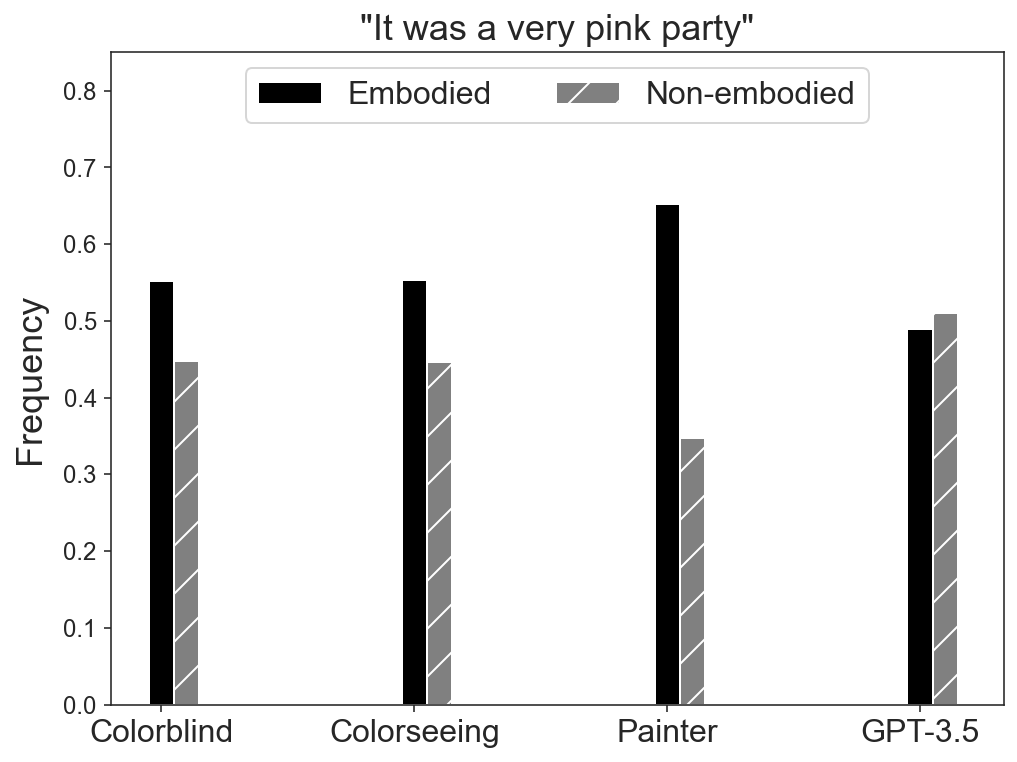

In [6]:
plt.figure(figsize=(8,6))

for i, key in enumerate(pink_categories_simple.keys()):
    print(key)
    plt.bar(i+np.array([0,0.1]),
            np.array(list(pink_categories_simple[key].values()))/np.sum(list(pink_categories_simple[key].values())),
            width=0.1,color=['black','gray'],hatch=['', '/'])
    
plt.bar(-0.5,
            np.array(list(pink_categories_simple[key].values()))/np.sum(list(pink_categories_simple[key].values())),
            width=0.1,color=['black'],hatch='',label='Embodied')

plt.bar(-0.5,
            np.array(list(pink_categories_simple[key].values()))/np.sum(list(pink_categories_simple[key].values())),
            width=0.1,color=['gray'],hatch='/',label='Non-embodied')

plt.xlim(-0.2,3.33)
plt.ylim(0,0.85)
plt.xticks([0,1,2,3],['Colorblind','Colorseeing','Painter','GPT-3.5'],fontsize=16)
plt.ylabel('Frequency',fontsize=18,labelpad=8)
plt.yticks(fontsize=12)
plt.legend(loc='upper center',ncol=2,fontsize=16)
plt.title('"It was a very pink party"',fontsize=18)
plt.show()

colorblind
colorseeing
painter
gpt


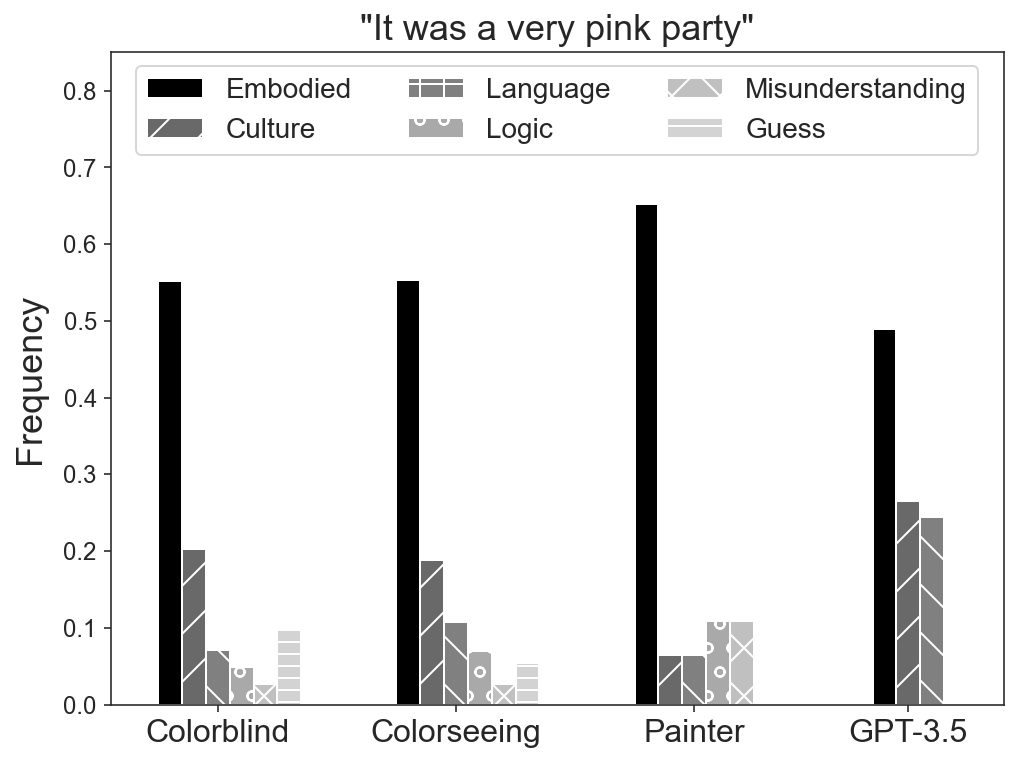

In [7]:
plt.figure(figsize=(8,6))

plot_labels=['Embodied','Culture','Language','Logic','Misunderstanding','Guess']

for i, key in enumerate(pink_categories.keys()):
    print(key)
    sc = plt.bar(i+np.array([0,0.1,0.2,0.3,0.4,0.5]),
            np.array(list(pink_categories[key].values()))/np.sum(list(pink_categories[key].values())),
            width=0.1,color=['black','dimgrey','gray','darkgray','silver','lightgray'],
                hatch=['','/','\\','o','x','--'])
    
plt.bar(np.ones(10)*-1.,-1,color='black',hatch='',label='Embodied')
plt.bar(np.ones(10)*-1.,-1,color='dimgrey',hatch='/',label='Culture')
plt.bar(np.ones(10)*-1.,-1,color='gray',hatch='+',label='Language')
plt.bar(np.ones(10)*-1.,-1,color='darkgray',hatch='o',label='Logic')
plt.bar(np.ones(10)*-1.,-1,color='silver',hatch='x',label='Misunderstanding')
plt.bar(np.ones(10)*-1.,-1,color='lightgray',hatch='--',label='Guess')

plt.xlim(-0.25,3.5)
plt.legend(loc='upper center',ncol=3,fontsize=14)
plt.xticks([0.2,1.2,2.2,3.1],['Colorblind','Colorseeing','Painter','GPT-3.5'],fontsize=16)
plt.ylabel('Frequency',fontsize=18,labelpad=8)
plt.yticks(fontsize=12)
plt.title('"It was a very pink party"',fontsize=18)

plt.ylim(0,0.85)
plt.show()

### Red Alert

In [8]:
red_codes = pd.read_csv('Thematic-Analysis-Red-Alert.csv',header=1,skiprows=0,skipfooter=279)
red_codes = red_codes.fillna(0)

In [9]:
red_codes_cb_cs_ids = []
red_codes_cb_cs_ids.extend([x for x in red_codes['ID'].values if x.startswith('CM')])
red_codes_cb_cs_ids.extend([x for x in red_codes['ID'].values if x.startswith('PR')])
red_codes_cb_cs_bools = np.zeros(len(red_codes))
for i in range(len(red_codes)):
    if red_codes['ID'].values[i] in red_codes_cb_cs_ids:
        red_codes_cb_cs_bools[i] = 1

red_cb = red_codes[(red_codes['Colorblind - Yes/1 or No/0'].values == 1) & (red_codes_cb_cs_bools == 1)]
red_cs = red_codes[(red_codes['Colorblind - Yes/1 or No/0'].values == 0) & (red_codes_cb_cs_bools == 1)]

###

red_codes_painter_ids = []
red_codes_painter_ids.extend([x for x in red_codes['ID'].values if x.startswith('P0')])
red_codes_painter_bools = np.zeros(len(red_codes))
for i in range(len(red_codes)):
    if red_codes['ID'].values[i] in red_codes_painter_ids:
        red_codes_painter_bools[i] = 1

red_painter = red_codes[(red_codes_painter_bools == 1)]

###

red_codes_gpt_ids = []
red_codes_gpt_ids.extend([x for x in red_codes['ID'].values if x.startswith('CH')])
red_codes_gpt_bools = np.zeros(len(red_codes))
for i in range(len(red_codes)):
    if red_codes['ID'].values[i] in red_codes_gpt_ids:
        red_codes_gpt_bools[i] = 1

red_gpt = red_codes[(red_codes_gpt_bools == 1)]

###

red_data = {'colorblind': red_cb, 'colorseeing': red_cs, 'painter': red_painter, 'gpt': red_gpt}

In [10]:
red_categories = {'colorblind': {}, 'colorseeing': {}, 'painter': {}, 'gpt': {}}

answer_to_category = {'Color perception': 'Embodied', 'Color association': 'Embodied',
                      'Emotional experience': 'Embodied','Past experiences': 'Embodied', 
                      'Stereotype/Culture': 'Society and Culture',
                     'Meaning/Context': 'Language', 'Past usage/responses': 'Language', 
                      'Logic/abstract instinct': 'Logic', 'Embodied Instinct': 'Embodied',
                      'Misunderstanding': 'Misunderstanding', 'Arb/Guess': 'Arbitrary/guesswork'}

for key in red_categories.keys():
    red_categories[key] = {'Embodied': 0., 'Society and Culture': 0., 'Language': 0., 'Logic': 0., 'Misunderstanding': 0.,
                           'Arbitrary/guesswork': 0.}
    for answer_type in answer_to_category.keys():
        red_categories[key][answer_to_category[answer_type]] += np.sum(red_data[key][answer_type].values)

In [11]:
#Example: compare rate of embodied vs. non-embodied responses within each group
red_categories_simple = {'colorblind': {}, 'colorseeing': {}, 'painter': {}, 'gpt': {}}

for key in red_categories.keys():
    print(key)
    red_categories_simple[key]['Embodied'] = red_categories[key]['Embodied']
    red_categories_simple[key]['Non-embodied'] = np.sum(list(red_categories[key].values()))-red_categories[key]['Embodied']
    print(proportions_ztest(red_categories[key]['Embodied'], np.sum(list(red_categories[key].values()))
                            ,value=0.5))

colorblind
(-5.395219329034882, 6.843989859462127e-08)
colorseeing
(-5.804829781368174, 6.443142668421023e-09)
painter
(0.33384893044479447, 0.7384935584158605)
gpt
(-20.242433093898956, 4.142073539466278e-91)


colorblind
colorseeing
painter
gpt


FileNotFoundError: [Errno 2] No such file or directory: 'color_survey_final/qualitative/red_alert_simple.png'

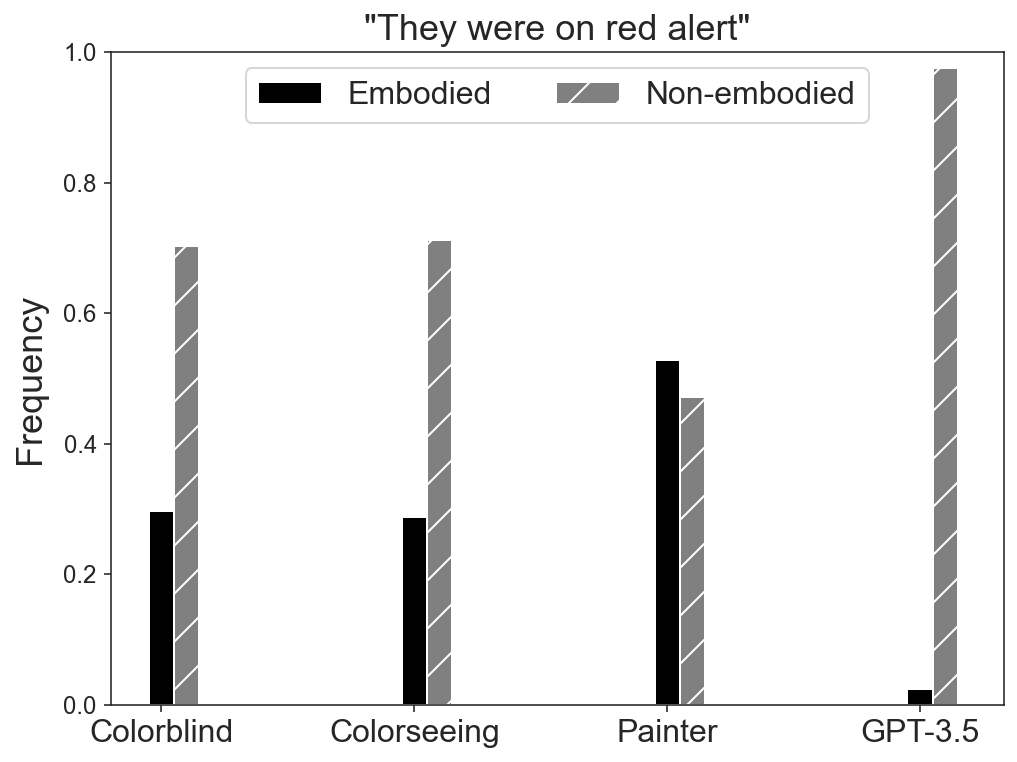

In [12]:
plt.figure(figsize=(8,6))

for i, key in enumerate(red_categories_simple.keys()):
    print(key)
    plt.bar(i+np.array([0,0.1]),
            np.array(list(red_categories_simple[key].values()))/np.sum(list(red_categories_simple[key].values())),
            width=0.1,color=['black','gray'],hatch=['','/'])
    
plt.bar(-0.5,
            np.array(list(red_categories_simple[key].values()))/np.sum(list(red_categories_simple[key].values())),
            width=0.1,color=['black'],hatch='',label='Embodied')

plt.bar(-0.5,
            np.array(list(red_categories_simple[key].values()))/np.sum(list(red_categories_simple[key].values())),
            width=0.1,color=['gray'],hatch='/',label='Non-embodied')

plt.xlim(-0.2,3.33)
plt.ylim(0,1.)
plt.xticks([0,1,2,3],['Colorblind','Colorseeing','Painter','GPT-3.5'],fontsize=16)
plt.ylabel('Frequency',fontsize=18,labelpad=8)
plt.yticks(fontsize=12)
plt.legend(loc='upper center',ncol=2,fontsize=16)
plt.title('"They were on red alert"',fontsize=18)
plt.savefig('color_survey_final/qualitative/red_alert_simple.png')
plt.show()

colorblind
colorseeing
painter
gpt


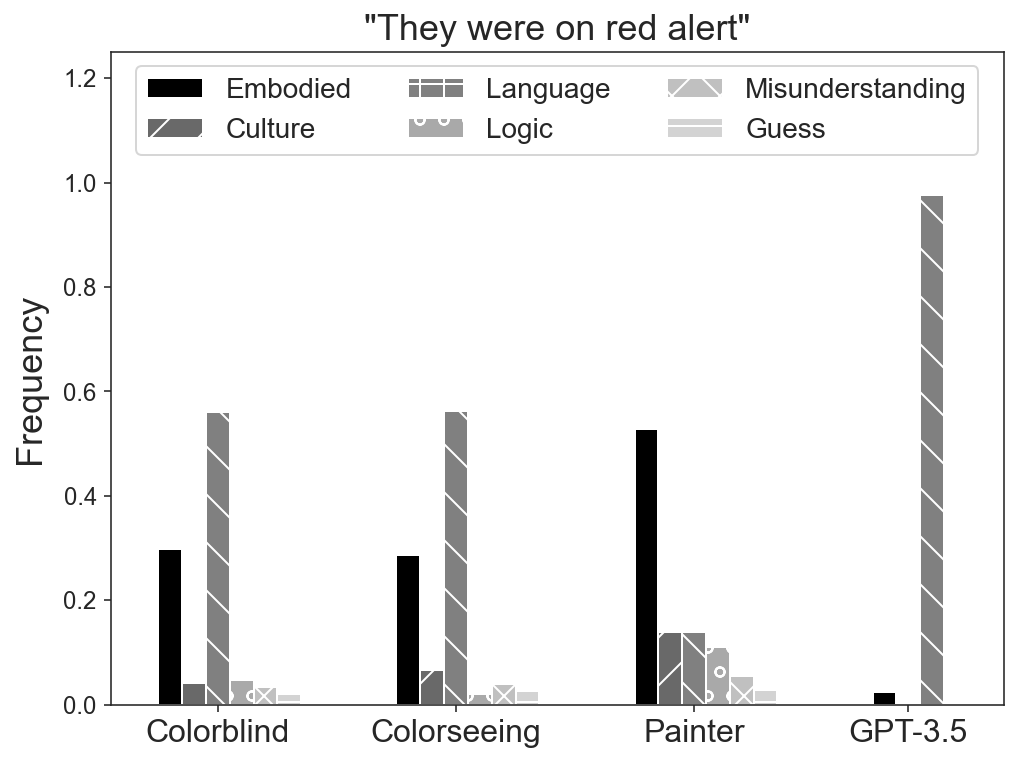

In [13]:
plt.figure(figsize=(8,6))

plot_labels=['Embodied','Culture','Language','Logic','Misunderstanding','Guess']

for i, key in enumerate(red_categories.keys()):
    print(key)
    sc = plt.bar(i+np.array([0,0.1,0.2,0.3,0.4,0.5]),
            np.array(list(red_categories[key].values()))/np.sum(list(red_categories[key].values())),
            width=0.1,color=['black','dimgrey','gray','darkgray','silver','lightgray'],
                hatch=['','/','\\','o','x','--'])
    
plt.bar(np.ones(10)*-1.,-1,color='black',hatch='',label='Embodied')
plt.bar(np.ones(10)*-1.,-1,color='dimgrey',hatch='/',label='Culture')
plt.bar(np.ones(10)*-1.,-1,color='gray',hatch='+',label='Language')
plt.bar(np.ones(10)*-1.,-1,color='darkgray',hatch='o',label='Logic')
plt.bar(np.ones(10)*-1.,-1,color='silver',hatch='x',label='Misunderstanding')
plt.bar(np.ones(10)*-1.,-1,color='lightgray',hatch='--',label='Guess')

plt.legend(loc='upper center',ncol=3,fontsize=14)
plt.xticks([0.2,1.2,2.2,3.1],['Colorblind','Colorseeing','Painter','GPT-3.5'],fontsize=16)
plt.ylabel('Frequency',fontsize=18,labelpad=8)
plt.yticks(fontsize=12)
plt.title('"They were on red alert"',fontsize=18)

plt.ylim(0,1.25)
plt.xlim(-0.25,3.5)
plt.show()